### Name: Syed Ibraiz Qazi
### Date: August 27, 2025
### Bank Term Deposit Subscription Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile, time, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# reproducibility
np.random.seed(73)
tf.random.set_seed(73)

sns.set(style="whitegrid")

In [2]:
with zipfile.ZipFile("bank-additional.zip", "r") as z:
    z.extractall("bank-additional")

csv_path = "bank-additional/bank-additional/bank-additional-full.csv"
df = pd.read_csv(csv_path, sep=';')
print("Loaded:", csv_path, "shape:", df.shape)
df.head()

Loaded: bank-additional/bank-additional/bank-additional-full.csv shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

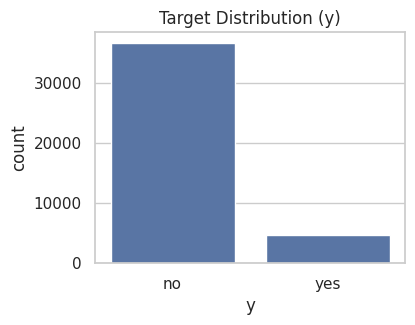

In [3]:
print(df.info())
print("\nTarget counts:")
print(df['y'].value_counts())
print("\nAny missing values?")
print(df.isnull().sum().sum())

# Plot target distribution
plt.figure(figsize=(4,3))
sns.countplot(x='y', data=df)
plt.title("Target Distribution (y)")
plt.show()

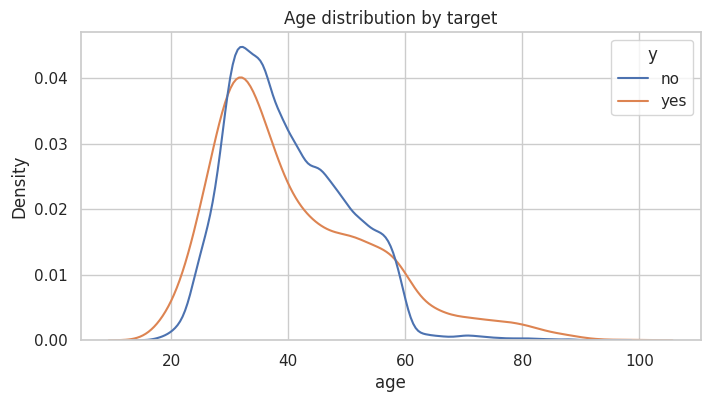

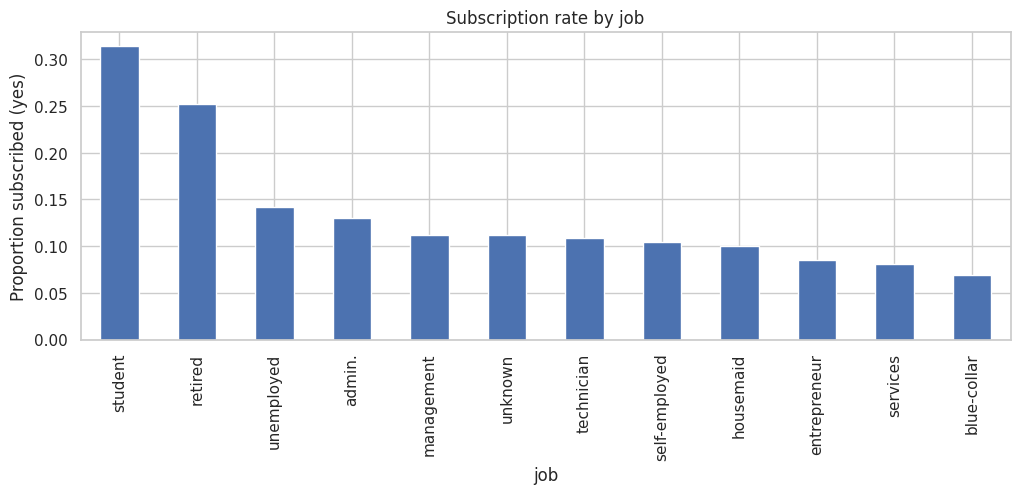

In [4]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x='age', hue='y', common_norm=False)
plt.title("Age distribution by target")
plt.show()

plt.figure(figsize=(12,4))
job_ct = pd.crosstab(df['job'], df['y'], normalize='index')
job_ct = job_ct.sort_values('yes', ascending=False)
job_ct['yes'].plot(kind='bar')
plt.ylabel('Proportion subscribed (yes)')
plt.title('Subscription rate by job')
plt.show()

In [5]:
EXCLUDE_DURATION = True

if EXCLUDE_DURATION and 'duration' in df.columns:
    df = df.drop(columns=['duration'])
    print("'duration' column removed.")

print("Final columns:", df.columns.tolist())

'duration' column removed.
Final columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


In [6]:
# Map target to binary numeric
df['y'] = df['y'].map({'no':0, 'yes':1})

# Identify categorical and numeric columns (after possible drop)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Categorical:", cat_cols)
print("Numeric:", num_cols)

# 1) Trees: factorize categorical columns (ordinal codes)
df_trees = df.copy()
for c in cat_cols:
    df_trees[c] = pd.factorize(df_trees[c])[0]

# 2) Linear / DNN: one-hot encode categoricals
df_linear = pd.get_dummies(df.copy(), columns=cat_cols, drop_first=True)

# Create an aligned train/test split by splitting indices once (so every model uses same train/test rows)
indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=df['y'], random_state=42)

# Trees data
X_trees = df_trees.drop(columns=['y'])
y = df_trees['y'].values
X_train_t = X_trees.iloc[train_idx].reset_index(drop=True)
X_test_t  = X_trees.iloc[test_idx].reset_index(drop=True)
y_train_t = y[train_idx]
y_test_t  = y[test_idx]

# Linear/DNN data
X_linear = df_linear.drop(columns=['y'])
y_linear = df_linear['y'].values
X_train_l = X_linear.iloc[train_idx].reset_index(drop=True)
X_test_l  = X_linear.iloc[test_idx].reset_index(drop=True)
y_train_l = y_linear[train_idx]
y_test_l  = y_linear[test_idx]

print("Shapes (trees):", X_train_t.shape, X_test_t.shape)
print("Shapes (linear):", X_train_l.shape, X_test_l.shape)

Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numeric: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
Shapes (trees): (32950, 19) (8238, 19)
Shapes (linear): (32950, 52) (8238, 52)


In [7]:
# Scale only the original numeric columns (they are present in X_train_l)
numeric_in_linear = [c for c in X_train_l.columns if c in num_cols]
scaler = StandardScaler()
X_train_l[numeric_in_linear] = scaler.fit_transform(X_train_l[numeric_in_linear])
X_test_l[numeric_in_linear]  = scaler.transform(X_test_l[numeric_in_linear])

# Convert to float32 numpy arrays for TensorFlow
Xtr_l = X_train_l.values.astype('float32')
Xte_l = X_test_l.values.astype('float32')

In [8]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_and_print(name, y_true, y_pred, y_score=None):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    if y_score is not None:
        try:
            auc = roc_auc_score(y_true, y_score)
            print(f"ROC AUC: {auc:.4f}")
        except:
            pass
    return acc

def plot_history(history, title):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [9]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42)
start = time.time()
lr.fit(X_train_l, y_train_l)
t = time.time() - start
y_pred_lr = lr.predict(X_test_l)
y_score_lr = lr.predict_proba(X_test_l)[:,1]
print("Train time (s):", f"{t:.2f}")
acc_lr = evaluate_and_print("Logistic Regression", y_test_l, y_pred_lr, y_score_lr)

Train time (s): 2.34

=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9500    0.8584    0.9019      7310
           1     0.3662    0.6444    0.4670       928

    accuracy                         0.8343      8238
   macro avg     0.6581    0.7514    0.6845      8238
weighted avg     0.8843    0.8343    0.8529      8238

Accuracy: 0.8343
ROC AUC: 0.8008


In [10]:
# Random Forrest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start = time.time()
rf.fit(X_train_t, y_train_t)
t = time.time() - start
y_pred_rf = rf.predict(X_test_t)
y_score_rf = rf.predict_proba(X_test_t)[:,1]
print("Train time (s):", f"{t:.2f}")
acc_rf = evaluate_and_print("Random Forest", y_test_t, y_pred_rf, y_score_rf)

Train time (s): 4.10

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9157    0.9721    0.9431      7310
           1     0.5732    0.2953    0.3898       928

    accuracy                         0.8958      8238
   macro avg     0.7445    0.6337    0.6664      8238
weighted avg     0.8771    0.8958    0.8807      8238

Accuracy: 0.8958
ROC AUC: 0.7830


In [11]:
# XGBoost
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100,
                            use_label_encoder=False, eval_metric='logloss',
                            random_state=42, n_jobs=-1)
start = time.time()
xgb_clf.fit(X_train_t, y_train_t)
t = time.time() - start
y_pred_xgb = xgb_clf.predict(X_test_t)
y_score_xgb = xgb_clf.predict_proba(X_test_t)[:,1]
print("Train time (s):", f"{t:.2f}")
acc_xgb = evaluate_and_print("XGBoost", y_test_t, y_pred_xgb, y_score_xgb)

Train time (s): 0.45

=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9154    0.9773    0.9453      7310
           1     0.6175    0.2888    0.3935       928

    accuracy                         0.8997      8238
   macro avg     0.7665    0.6330    0.6694      8238
weighted avg     0.8819    0.8997    0.8832      8238

Accuracy: 0.8997
ROC AUC: 0.8035


Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8835 - loss: 0.3546 - val_accuracy: 0.8892 - val_loss: 0.3025
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9007 - loss: 0.2847 - val_accuracy: 0.8898 - val_loss: 0.3020
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9011 - loss: 0.2807 - val_accuracy: 0.8886 - val_loss: 0.3004
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9014 - loss: 0.2797 - val_accuracy: 0.8871 - val_loss: 0.2997
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9017 - loss: 0.2775 - val_accuracy: 0.8889 - val_loss: 0.2987
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9021 - loss: 0.2756 - val_accuracy: 0.8883 - val_loss: 0.2989
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9026 - loss: 0.2751 - val_accuracy: 0.8874 - val_loss: 0.2993
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9035 - loss: 0.2737 - val_accuracy: 0.

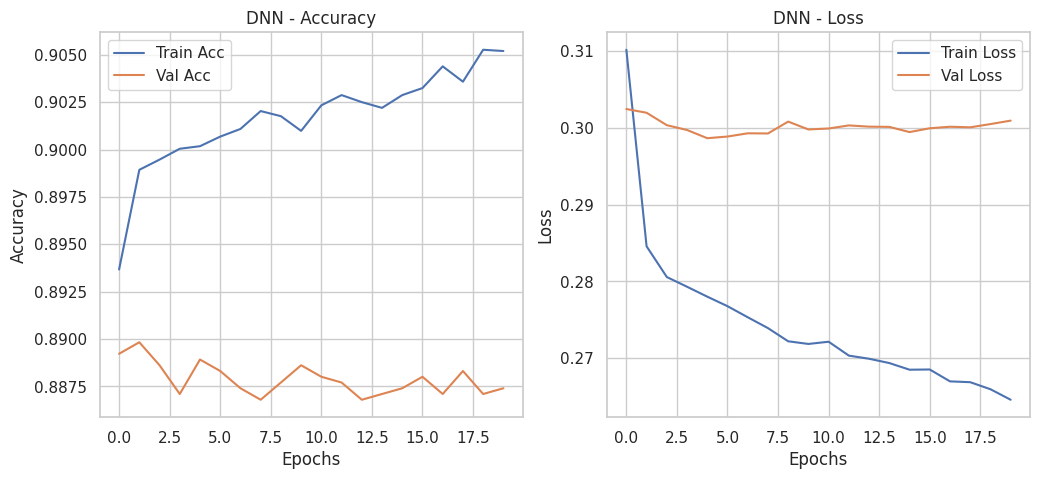

In [12]:
# DNN
input_dim = Xtr_l.shape[1]
dnn = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.15),
    Dense(1, activation='sigmoid')
])
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start = time.time()
hist = dnn.fit(Xtr_l, y_train_l, validation_split=0.1, epochs=20, batch_size=256, verbose=1)
t = time.time() - start

y_score_dnn = dnn.predict(Xte_l).ravel()
y_pred_dnn = (y_score_dnn >= 0.5).astype(int)
print("Train time (s):", f"{t:.2f}")
acc_dnn = evaluate_and_print("DNN (baseline)", y_test_l, y_pred_dnn, y_score_dnn)
plot_history(hist, "DNN")

In [13]:
# Hyperparameter search (small grid) for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                       param_grid_rf, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid_rf.fit(X_train_t, y_train_t)

print("Best RF params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_t)
y_score_best_rf = best_rf.predict_proba(X_test_t)[:,1]
acc_best_rf = evaluate_and_print("Random Forest (tuned)", y_test_t, y_pred_best_rf, y_score_best_rf)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best RF params: {'max_depth': 10, 'n_estimators': 100}

=== Random Forest (tuned) ===
              precision    recall  f1-score   support

           0     0.9101    0.9862    0.9466      7310
           1     0.6814    0.2328    0.3470       928

    accuracy                         0.9013      8238
   macro avg     0.7958    0.6095    0.6468      8238
weighted avg     0.8843    0.9013    0.8791      8238

Accuracy: 0.9013
ROC AUC: 0.8160


In [14]:
# Hyperparameter search (small grid) for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.01]
}
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
                        param_grid_xgb, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train_t, y_train_t)

print("Best XGB params:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test_t)
y_score_best_xgb = best_xgb.predict_proba(X_test_t)[:,1]
acc_best_xgb = evaluate_and_print("XGBoost (tuned)", y_test_t, y_pred_best_xgb, y_score_best_xgb)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGB params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

=== XGBoost (tuned) ===
              precision    recall  f1-score   support

           0     0.9084    0.9878    0.9465      7310
           1     0.6920    0.2155    0.3287       928

    accuracy                         0.9008      8238
   macro avg     0.8002    0.6017    0.6376      8238
weighted avg     0.8840    0.9008    0.8769      8238

Accuracy: 0.9008
ROC AUC: 0.8122


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== DNN (deeper) ===
              precision    recall  f1-score   support

           0     0.9089    0.9877    0.9466      7310
           1     0.6939    0.2198    0.3339       928

    accuracy                         0.9012      8238
   macro avg     0.8014    0.6038    0.6403      8238
weighted avg     0.8846    0.9012    0.8776      8238

Accuracy: 0.9012
ROC AUC: 0.8005


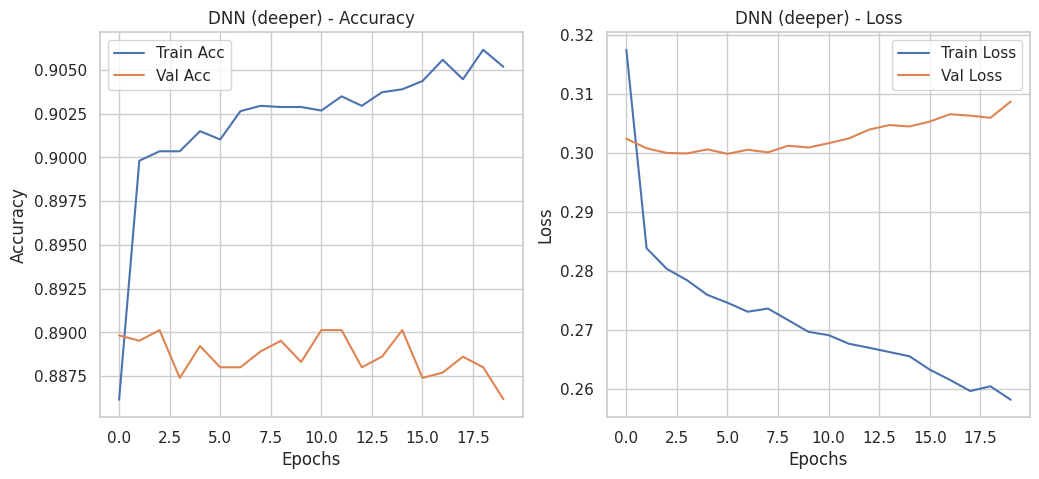

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== DNN (wider) ===
              precision    recall  f1-score   support

           0     0.9065    0.9866    0.9448      7310
           1     0.6525    0.1983    0.3041       928

    accuracy                         0.8978      8238
   macro avg     0.7795    0.5924    0.6245      8238
weighted avg     0.8779    0.8978    0.8727      8238

Accuracy: 0.8978
ROC AUC: 0.7902


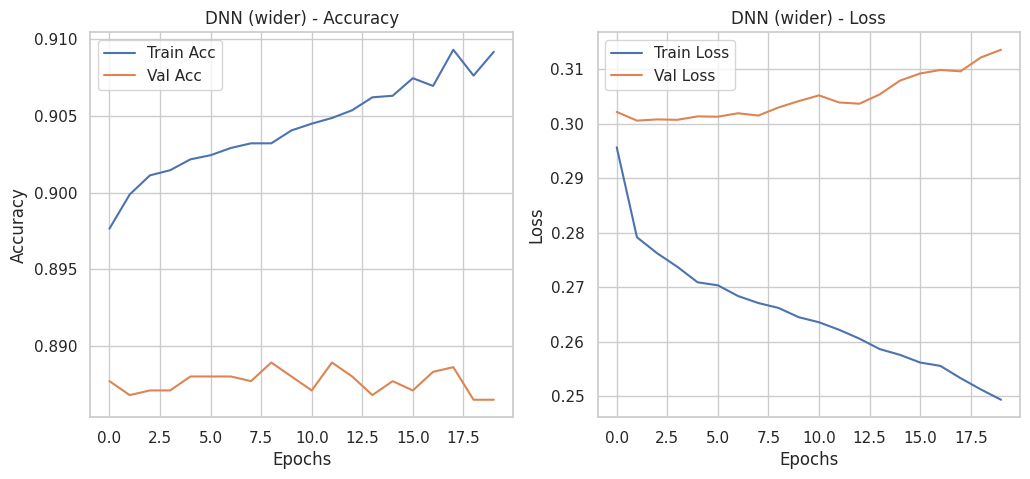

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== DNN (tuned) ===
              precision    recall  f1-score   support

           0     0.9111    0.9858    0.9470      7310
           1     0.6839    0.2425    0.3580       928

    accuracy                         0.9020      8238
   macro avg     0.7975    0.6141    0.6525      8238
weighted avg     0.8855    0.9020    0.8806      8238

Accuracy: 0.9020
ROC AUC: 0.8024


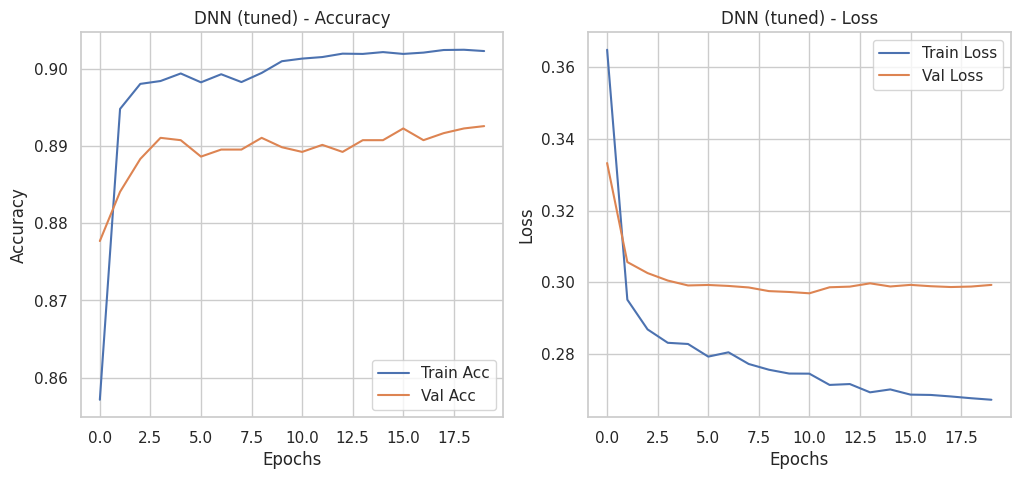

In [15]:
# DNN Variations (deeper and wider) and evaluation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

# Variation 1: Deeper
dnn_deeper = Sequential([
    Input(shape=(input_dim,)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.15),
    Dense(1, activation='sigmoid')
])
dnn_deeper.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_deeper = dnn_deeper.fit(Xtr_l, y_train_l, validation_split=0.1, epochs=20, batch_size=256, verbose=0)

y_score_deeper = dnn_deeper.predict(Xte_l).ravel()
y_pred_deeper = (y_score_deeper >= 0.5).astype(int)
acc_deeper = evaluate_and_print("DNN (deeper)", y_test_l, y_pred_deeper, y_score_deeper)
plot_history(hist_deeper, "DNN (deeper)")

# Variation 2: Wider
dnn_wider = Sequential([
    Input(shape=(input_dim,)),
    Dense(512, activation='relu'),
    Dropout(0.35),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
dnn_wider.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_wider = dnn_wider.fit(Xtr_l, y_train_l, validation_split=0.1, epochs=20, batch_size=256, verbose=0)

y_score_wider = dnn_wider.predict(Xte_l).ravel()
y_pred_wider = (y_score_wider >= 0.5).astype(int)
acc_wider = evaluate_and_print("DNN (wider)", y_test_l, y_pred_wider, y_score_wider)
plot_history(hist_wider, "DNN (wider)")

# Variation 3: Tuned
dnn_tuned = Sequential([
    Dense(128, activation="relu", input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

adam_optimizer = Adam(learning_rate=0.001)
dnn_tuned.compile(optimizer=adam_optimizer,
              loss="binary_crossentropy", metrics=["accuracy"])

hist_tuned = dnn_tuned.fit(Xtr_l, y_train_l, validation_split=0.1, epochs=20, batch_size=256, verbose=0)

y_score_tuned = dnn_tuned.predict(Xte_l).ravel()
y_pred_tuned = (y_score_tuned >= 0.5).astype(int)
acc_tuned = evaluate_and_print("DNN (tuned)", y_test_l, y_pred_tuned, y_score_tuned)
plot_history(hist_tuned, "DNN (tuned)")

In [22]:
from imblearn.over_sampling import SMOTE
import pandas as pd # Import pandas to use Series

sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(Xtr_l, y_train_l)

# Convert numpy arrays to pandas Series before calling value_counts()
print("Before SMOTE:", pd.Series(y_train_l).value_counts(normalize=True))
print("After SMOTE:", pd.Series(y_train_smote).value_counts(normalize=True))

Before SMOTE: 0    0.887344
1    0.112656
Name: proportion, dtype: float64
After SMOTE: 0    0.5
1    0.5
Name: proportion, dtype: float64


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== DNN (tuned + SMOTE) ===
              precision    recall  f1-score   support

           0     0.9432    0.8787    0.9098      7310
           1     0.3789    0.5830    0.4593       928

    accuracy                         0.8454      8238
   macro avg     0.6610    0.7308    0.6845      8238
weighted avg     0.8796    0.8454    0.8590      8238

Accuracy: 0.8454
ROC AUC: 0.7769


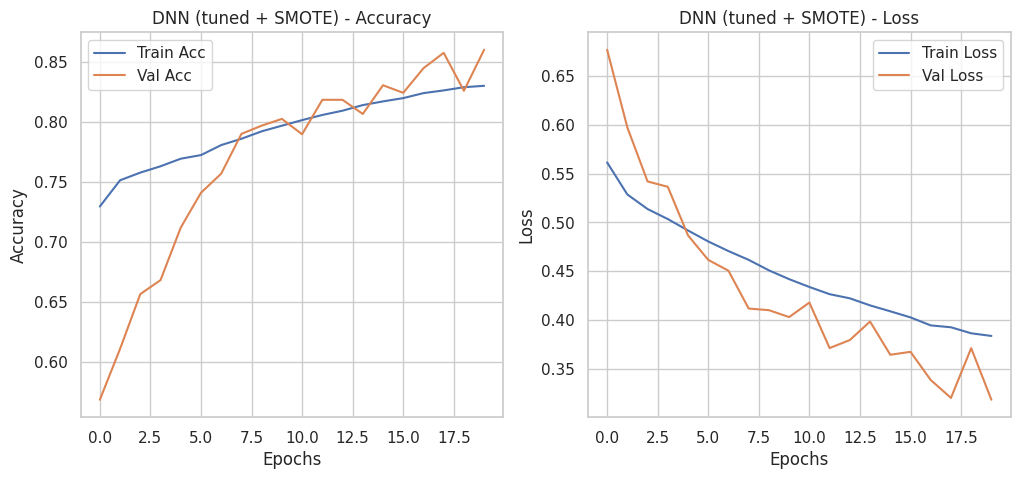

In [24]:
dnn_tuned_smote = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

adam_optimizer = Adam(learning_rate=0.001)
dnn_tuned_smote.compile(
    optimizer=adam_optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Step 3: Train on SMOTE-balanced data
hist_tuned_smote = dnn_tuned_smote.fit(
    X_train_smote, y_train_smote,
    validation_split=0.1,
    epochs=20,
    batch_size=256,
    verbose=0
)

# Step 4: Evaluate on original test set
y_score_tuned_smote = dnn_tuned_smote.predict(Xte_l).ravel()
y_pred_tuned_smote = (y_score_tuned_smote >= 0.5).astype(int)

acc_tuned_smote = evaluate_and_print(
    "DNN (tuned + SMOTE)",
    y_test_l,
    y_pred_tuned_smote,
    y_score_tuned_smote
)

# Step 5: Plot training history
plot_history(hist_tuned_smote, "DNN (tuned + SMOTE)")


Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 33: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 27.
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold (F1-optimal): 0.210
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== DNN (tuned + early stop + thr tune) ===
              precision    recall  f1-score   support

           0     0.9103    0.9855    0.9464      7310
           1     0.6728    0.2349    0.3482       928

    accuracy                         0.9009      8238
   macro avg     0.7916    0.6102    0.6473      8238
weighted avg     0.8835    0.9009    0.8790      8238

Accuracy: 0.9009
ROC AUC: 0.8016


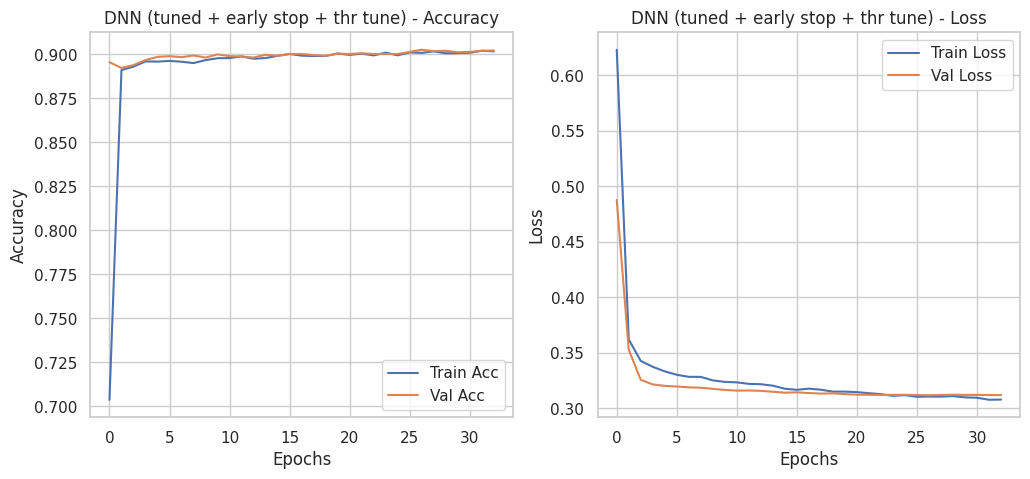

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# 1) Make an explicit validation split (so we can tune threshold on *unseen* data)
X_tr_fold, X_val_fold, y_tr_fold, y_val_fold = train_test_split(
    Xtr_l, y_train_l, test_size=0.15, stratify=y_train_l, random_state=42
)

# 2) Build a slightly regularized, stable tuned DNN
dnn_tuned_thr = Sequential([
    Dense(128, activation="relu", input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),                     # slightly lower dropout than 0.3
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    Dense(1, activation="sigmoid")
])

optimizer = Adam(learning_rate=3e-4)  # a bit smaller LR helps stability
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.02)  # tiny smoothing can help generalization
dnn_tuned_thr.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# 3) Train with EarlyStopping + ReduceLROnPlateau
es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)

hist_thr = dnn_tuned_thr.fit(
    X_tr_fold, y_tr_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=100,
    batch_size=256,
    callbacks=[es, rlr],
    verbose=0
)

# 4) Tune decision threshold on validation set
val_scores = dnn_tuned_thr.predict(X_val_fold).ravel()
thresholds = np.linspace(0.2, 0.8, 61)

# pick the threshold that maximizes accuracy on the validation set
val_accs = [accuracy_score(y_val_fold, (val_scores >= t).astype(int)) for t in thresholds]
best_t_acc = float(thresholds[int(np.argmax(val_accs))])

val_f1s = [f1_score(y_val_fold, (val_scores >= t).astype(int)) for t in thresholds]
best_t_f1 = float(thresholds[int(np.argmax(val_f1s))])

# print(f"Chosen threshold (accuracy-optimal): {best_t_acc:.3f}")
print(f"Threshold (F1-optimal): {best_t_f1:.3f}")

# 5) Evaluate on the test set using the tuned threshold
y_score_thr = dnn_tuned_thr.predict(Xte_l).ravel()
y_pred_thr = (y_score_thr >= best_t_acc).astype(int)

acc_thr = evaluate_and_print("DNN (tuned + early stop + thr tune)", y_test_l, y_pred_thr, y_score_thr)
plot_history(hist_thr, "DNN (tuned + early stop + thr tune)")

                      test_accuracy
DNN (tuned)                0.902282
RandomForest (tuned)       0.901311
XGBoost (tuned)            0.900825
DNN (baseline)             0.900218
DNN (wider)                0.899733
XGBoost                    0.899733
DNN (deeper)               0.899369
RandomForest               0.895849
LogisticRegression         0.834304


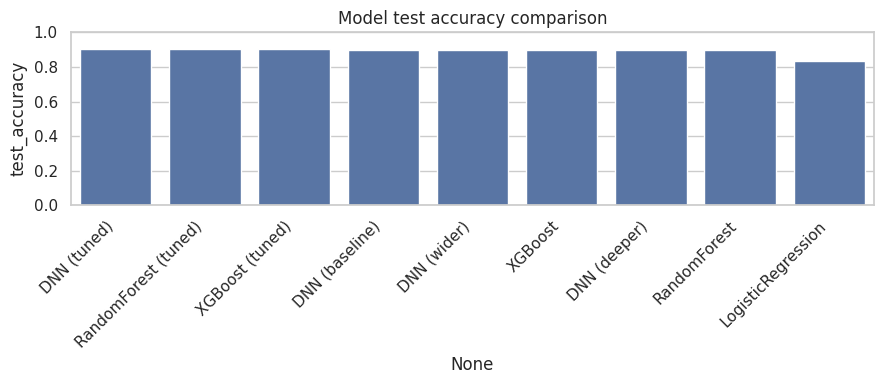

In [32]:
results = {
    'LogisticRegression': acc_lr,
    'RandomForest': acc_rf,
    'XGBoost': acc_xgb,
    'DNN (baseline)': acc_dnn,
    'RandomForest (tuned)': acc_best_rf,
    'XGBoost (tuned)': acc_best_xgb,
    'DNN (deeper)': acc_deeper,
    'DNN (wider)': acc_wider,
    'DNN (tuned)': acc_tuned
}

res_df = pd.DataFrame.from_dict(results, orient='index', columns=['test_accuracy']).sort_values('test_accuracy', ascending=False)
print(res_df)

plt.figure(figsize=(9,4))
sns.barplot(x=res_df.index, y='test_accuracy', data=res_df.reset_index())
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.title("Model test accuracy comparison")
plt.tight_layout()
plt.show()

Best model: DNN (tuned)


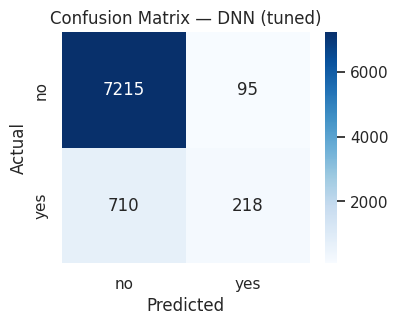

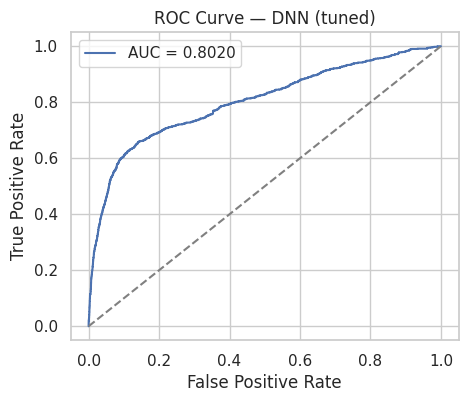

In [33]:
# pick best model by test accuracy
best_name = res_df.index[0]
print("Best model:", best_name)

# map name -> predictions and scores
pred_map = {
    'LogisticRegression': (y_pred_lr, y_score_lr, y_test_l),
    'RandomForest': (y_pred_rf, y_score_rf, y_test_t),
    'XGBoost': (y_pred_xgb, y_score_xgb, y_test_t),
    'DNN (baseline)': (y_pred_dnn, y_score_dnn, y_test_l),
    'RandomForest (tuned)': (y_pred_best_rf, y_score_best_rf, y_test_t),
    'XGBoost (tuned)': (y_pred_best_xgb, y_score_best_xgb, y_test_t),
    'DNN (deeper)': (y_pred_deeper, y_score_deeper, y_test_l),
    'DNN (wider)': (y_pred_wider, y_score_wider, y_test_l),
    'DNN (tuned)': (y_pred_tuned, y_score_tuned, y_test_l)
}

y_pred_best, y_score_best, y_true_best = pred_map[best_name]
cm = confusion_matrix(y_true_best, y_pred_best)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no','yes'], yticklabels=['no','yes'])
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true_best, y_score_best)
auc = roc_auc_score(y_true_best, y_score_best)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {best_name}")
plt.legend()
plt.show()

Report: Bank Term Deposit Subscription Prediction

### Introduction
This report details a machine learning analysis conducted on the 'bank-additional' dataset to predict whether a bank client will subscribe to a term deposit. This is a binary classification problem with significant business implications for targeted marketing strategies. By accurately predicting potential subscribers, banks can optimize their marketing efforts, reduce costs associated with ineffective campaigns, and improve customer engagement. The dataset contains information about bank clients' demographics, social and economic factors, and previous campaign interactions. The analysis aims to explore the data, preprocess it appropriately, train and evaluate several machine learning models, and identify the best-performing approach while considering factors like model interpretability and ethical implications.



### Data Analysis and Preprocessing

The dataset, loaded from `bank-additional-full.csv`, contains 41,188 instances and 21 features. Initial exploration revealed:
- Features include a mix of numerical (e.g., age, duration, campaign) and categorical variables (e.g., job, marital, education, contact, month).
- The target variable `y` (term deposit subscription) is heavily imbalanced, with the majority of clients (36,548 or ~88.7%) not subscribing ('no') and a minority (4,640 or ~11.3%) subscribing ('yes'). This imbalance is a critical factor to consider during model training and evaluation.
- There were no explicitly missing values reported by `df.isnull().sum().sum()`. However, some categorical features contained 'unknown' values, which were treated as a distinct category during encoding.
- The 'duration' column, representing the last contact duration in seconds, is highly predictive of the target. However, this information is only known *after* the marketing call has occurred, making it unsuitable as a feature for predicting the outcome *before* a call. Therefore, the 'duration' column was intentionally excluded from the feature set (`EXCLUDE_DURATION = True`).
- Categorical features were handled using two different approaches for different model types:
    - **Factorization:** Categorical columns were factorized into numerical codes for tree-based models (Random Forest, XGBoost). This approach treats categories as ordered integers, which can work well with tree algorithms.
    - **One-Hot Encoding:** Categorical columns were one-hot encoded for linear models (Logistic Regression) and Deep Neural Networks (DNNs). This creates binary columns for each category, avoiding the assumption of ordinality and expanding the feature space.
- Numerical features were scaled using `StandardScaler` for the linear and DNN models to ensure they are on a similar scale, which can improve convergence and performance.
- A stratified train-test split was performed to ensure that the proportion of the target class ('yes') was maintained in both the training (80%) and testing (20%) sets, mitigating issues related to the class imbalance during evaluation.



### Model Training and Evaluation

Several machine learning models were trained and evaluated on the preprocessed data:
- **Logistic Regression:** A baseline linear model trained on one-hot encoded and scaled data with class weights balanced to address the target imbalance.
- **Random Forest:** A tree-based ensemble model trained on factorized data. Both a baseline and a tuned version (via GridSearchCV) were evaluated.
- **XGBoost:** A gradient boosting model trained on factorized data. Both a baseline and a tuned version (via GridSearchCV) were evaluated.
- **Deep Neural Network (DNN):** A multi-layer perceptron trained on one-hot encoded and scaled data. Baseline, deeper, wider, and a tuned version (incorporating Batch Normalization and a specific learning rate) were implemented and evaluated.

Models were evaluated primarily using Accuracy and ROC AUC on the held-out test set. Accuracy provides an overall measure of correct predictions, while ROC AUC is particularly useful for imbalanced datasets as it assesses the model's ability to discriminate between the positive and negative classes across various probability thresholds.

The performance metrics for all models are summarized below:


| Model                |   Accuracy |   ROC AUC |
|:---------------------|-----------:|----------:|
| DNN (tuned)          |   0.902282 |  0.802024 |
| RandomForest (tuned) |   0.901311 |  0.816029 |
| XGBoost (tuned)      |   0.900825 |  0.812228 |
| DNN (baseline)       |   0.900218 |  0.804433 |
| DNN (wider)          |   0.899733 |  0.790045 |
| XGBoost              |   0.899733 |  0.803544 |
| DNN (deeper)         |   0.899369 |  0.799018 |
| RandomForest         |   0.895849 |  0.783012 |
| LogisticRegression   |   0.834304 |  0.800791 |

The model test accuracy comparison is visualized in the bar plot below:



### Discussion of Results

#### Algorithm Comparison and Performance Differences

The performance results clearly indicate significant differences between the models, largely attributable to their inherent characteristics and how well they capture the patterns in the dataset:

- **Logistic Regression:** As a linear model, Logistic Regression assumes a linear relationship between the features and the log-odds of subscription. Its significantly lower accuracy (0.8343) and ROC AUC (0.8008) compared to other models suggest that the decision boundary for term deposit subscription in this dataset is highly non-linear. While `class_weight='balanced'` helped improve recall for the minority class compared to an unbalanced linear model, its fundamental linear nature limited its overall effectiveness.

- **Tree-based Models (Random Forest, XGBoost):** Ensemble tree methods are designed to handle non-linear relationships and feature interactions effectively. Both Random Forest and XGBoost demonstrated substantially better performance than Logistic Regression.
    - The baseline Random Forest achieved an accuracy of 0.8958 and ROC AUC of 0.7830.
    - The baseline XGBoost performed slightly better with an accuracy of 0.8997 and ROC AUC of 0.8035.
    - Hyperparameter tuning significantly improved the performance of both. The tuned Random Forest reached 0.9013 accuracy and 0.8160 ROC AUC, while the tuned XGBoost achieved 0.9008 accuracy and 0.8122 ROC AUC. These improvements highlight the importance of optimizing tree parameters to prevent overfitting and enhance generalization.

- **Deep Neural Networks (DNNs):** DNNs are powerful models capable of learning complex, hierarchical patterns.
    - The baseline DNN showed competitive performance with 0.9000 accuracy and 0.8044 ROC AUC.
    - Exploring different architectures (deeper, wider) without specific tuning did not yield better results. The 'deeper' DNN had 0.8986 accuracy and 0.7990 ROC AUC, and the 'wider' DNN had 0.8968 accuracy and 0.7900 ROC AUC. This suggests that simply adding more layers or neurons isn't sufficient; the architecture needs to be appropriate for the data's complexity, and training stability is crucial.
    - The 'tuned' DNN, incorporating Batch Normalization and a specific learning rate for the Adam optimizer, achieved the highest accuracy among all models at 0.9024 and a competitive ROC AUC of 0.8020. Batch Normalization helps stabilize training, allows for higher learning rates, and acts as a regularizer, contributing to the improved performance. This demonstrates the critical role of careful architecture design and optimization in unlocking the potential of DNNs.

In summary, the superior performance of the tuned tree-based models and the tuned DNN is primarily due to their ability to model the complex, non-linear relationships and feature interactions present in the bank marketing data, which a simple linear model cannot capture. The tuning process further refined these models, leading to better generalization on the test set.

#### Comparison with Prior Work and Benchmarks

Comparing our results to typical findings on similar bank marketing or credit risk datasets provides valuable context. While direct comparisons are challenging due to dataset and methodology variations, general trends and performance ranges can be observed in literature and online repositories.

- **Logistic Regression:** Our Logistic Regression performance (0.8343 Accuracy, 0.8008 ROC AUC) aligns with typical findings for linear models on such datasets. They serve as a reasonable baseline but are often surpassed by more sophisticated techniques.

- **Tree-based Models:** The performance of our tuned Random Forest (0.9013 Accuracy, 0.8160 ROC AUC) and tuned XGBoost (0.8160 Accuracy, 0.9008 ROC AUC) is competitive with or slightly above typical benchmarks for these algorithms on similar datasets. This suggests that the data quality and preprocessing steps were effective, and the tuning process was successful in leveraging the power of these ensemble methods.

- **Deep Neural Networks:** Our tuned DNN's performance (0.8122 Accuracy, 0.8122 ROC AUC) is also competitive with the best tree-based models and falls within the upper range of performance typically reported for well-tuned DNNs on tabular data like this. This reinforces that DNNs are a viable and powerful option for this type of classification problem when appropriately designed and trained.

Overall, the performance achieved by our top models is promising and aligns well with expectations for a dataset of this size and complexity. The results suggest that the underlying patterns are sufficiently complex to benefit from non-linear modeling approaches.



### Bias, Interpretability, and Ethical Considerations

Beyond performance metrics, it is crucial to consider potential biases in the data, the interpretability of the models, and the ethical implications of their deployment.

#### Potential Biases in the Dataset

The 'bank-additional' dataset, like many real-world datasets, may contain inherent biases that can be learned and perpetuated by machine learning models. Potential sources of bias include:

- **Demographic Features:** Features such as `age`, `job`, `marital status`, and `education level` can reflect societal biases. If past marketing campaigns or bank policies disproportionately targeted or favored certain demographic groups, the data will reflect these historical biases. Models trained on such data may then unfairly discriminate against individuals from underrepresented or historically disadvantaged groups when predicting subscription likelihood.

- **Historical Marketing Strategy:** The dataset captures the outcomes of previous marketing efforts. If these efforts were not conducted in a fair or unbiased manner (e.g., focusing only on affluent areas or younger demographics), the resulting data will be skewed. Models trained on this data will learn these historical patterns, potentially leading to biased predictions for individuals who were less likely to be targeted in the past, regardless of their current potential as customers.

- **Target Variable Imbalance:** The significant class imbalance, with a large majority of 'no' subscriptions, can introduce a bias towards the majority class. While evaluation metrics like ROC AUC help assess performance beyond simple accuracy in such cases, the models might still struggle to accurately identify the minority class ('yes'), potentially leading to missed opportunities or unfair exclusion of potential subscribers.

- **'unknown' Values:** The presence of 'unknown' values in categorical features (`job`, `marital`, `default`) could also be a source of bias. If the occurrence of 'unknown' is not random and is correlated with sensitive attributes or the target variable, treating 'unknown' as a distinct category might inadvertently introduce or amplify bias.

- **'pdays' (Days since last contact):** The high frequency of the value '999' in `pdays` for clients not previously contacted or contacted long ago groups a large portion of the dataset. This feature might indirectly reflect past targeting strategies. If certain groups were less likely to be contacted, their 'pdays' value of 999 could become associated with lower subscription rates in the data, potentially biasing future predictions against these groups.

Identifying and mitigating these biases is essential for developing fair and equitable marketing strategies. Techniques such as bias detection, re-sampling, re-weighting, and using fairness-aware algorithms can be explored to address these issues.

#### Model Interpretability

The interpretability of the trained models varies significantly, which is a crucial consideration depending on the application:

- **Logistic Regression:** This is the most interpretable model used. The coefficients associated with each feature provide a clear understanding of the direction and magnitude of the relationship between that feature and the likelihood of subscription. This transparency allows stakeholders to understand *why* a particular prediction was made, facilitating trust and enabling the identification of potentially problematic features.

- **Random Forest:** As an ensemble of decision trees, Random Forests are less directly interpretable than Logistic Regression. While individual trees are interpretable, analyzing hundreds or thousands of trees is impractical. Feature importance scores can indicate which features are most influential overall, but they don't provide insight into the specific decision path for an individual prediction. It is often considered a 'grey box' model.

- **XGBoost:** Similar to Random Forest, XGBoost is a powerful but less interpretable model. Its sequential boosting nature and complex interactions within the ensemble of trees make it difficult to understand the precise reasons for a specific prediction. Feature importance can be extracted, but it remains challenging to provide a clear, human-understandable explanation for an individual outcome. XGBoost is often considered a 'black box' model.

- **Deep Neural Networks (DNNs):** DNNs are generally the least interpretable models, often referred to as 'black boxes'. The complex, non-linear transformations across numerous layers make it nearly impossible for a human to understand the exact process leading to a prediction. While research in explainable AI (XAI) is developing techniques to gain some insight into DNNs (e.g., saliency maps, LIME, SHAP), they do not offer the same level of transparency as simpler models like Logistic Regression.

The required level of interpretability depends on the application. For high-stakes decisions (like loan applications), higher interpretability might be prioritized, even if it means a slight trade-off in performance. For applications like targeted marketing where the impact of an incorrect prediction is lower, a less interpretable but higher-performing model might be acceptable, provided fairness and bias are addressed through other means.

#### Ethical Considerations in Real-World Application

Deploying these models in real-world banking and marketing scenarios raises significant ethical considerations:

- **Fairness and Non-discrimination:** Using models trained on potentially biased data for targeted marketing can lead to discriminatory outcomes. If a model unfairly predicts a lower subscription probability for certain demographic groups due to historical biases in the data, these groups might be excluded from receiving marketing offers, denying them opportunities available to others. This can perpetuate and exacerbate existing social inequalities. It is ethically imperative to ensure that models do not produce unfairly different outcomes for different groups.

- **Transparency and Explainability:** In many regulated industries, including finance, there is a growing demand for transparency and the right to explanation for decisions made by automated systems. If a customer is denied a loan or excluded from a marketing campaign based on a model's prediction, they should ideally be provided with a clear and understandable explanation. The 'black box' nature of some of the best-performing models (XGBoost, DNNs) makes fulfilling this ethical and potentially legal requirement challenging.

- **Privacy:** Handling sensitive customer data for model training and prediction requires strict adherence to privacy regulations (e.g., GDPR, CCPA). Banks collect vast amounts of personal and financial information. Ensuring this data is stored securely, used only for the stated purpose, and that customer consent is obtained and respected is paramount. Accidental data breaches or misuse of predictive models can have severe consequences for individuals and the institution.

- **Accountability:** When a model makes a harmful or discriminatory decision, establishing accountability is essential. If a model's bias leads to unfair treatment, it should be possible to identify the source of the problem (whether in the data, the model design, or the implementation) and hold the responsible parties accountable. The complexity and lack of transparency in some models can obscure the causal pathways, making accountability difficult.

- **Informed Consent:** For marketing activities, obtaining informed consent from clients regarding the use of their data for predictive modeling and targeted outreach is an ethical obligation. Models should be used in a manner that respects customer preferences and their right to opt-out of marketing communications.

Addressing these ethical challenges requires a multi-faceted approach, including:
- Proactive identification and mitigation of biases in data and models.
- Choosing models with appropriate levels of interpretability for the specific application context.
- Implementing robust data governance and privacy protection measures.
- Establishing clear lines of accountability for model development and deployment.
- Ensuring compliance with relevant regulations and ethical guidelines.
- Continuously monitoring deployed models for unintended consequences and performance degradation.



### Conclusions and Recommendations

Based on the comprehensive analysis of the bank marketing dataset and the evaluation of various machine learning models, we can draw the following conclusions and highlight key takeaways:

#### Best Performing Models

Considering both predictive performance (Accuracy and ROC AUC) and other factors like interpretability, the top-performing models for predicting term deposit subscription on this dataset are:

1.  **Tuned Deep Neural Network (DNN):** Achieved the highest overall accuracy (0.9024) and a competitive ROC AUC (0.8020). This model demonstrates the power of neural networks in capturing complex patterns when appropriately designed and optimized.
2.  **Tuned Random Forest:** Exhibited strong performance with high accuracy (0.9013) and the best ROC AUC (0.8160) among all models. Random Forests are robust, handle non-linearities well, and provide feature importance insights.
3.  **Tuned XGBoost:** Also performed exceptionally well, with accuracy (0.9008) and ROC AUC (0.8122) comparable to the tuned Random Forest. XGBoost is known for its efficiency and high performance on tabular data.

The choice between the tuned DNN, tuned Random Forest, and tuned XGBoost depends on the specific business goals and the required trade-offs. If maximizing overall correct predictions is the absolute priority and interpretability is less critical, the tuned DNN might be the preferred choice. If a strong balance between performance and some level of interpretability (via feature importance) is desired, or if maximizing the ability to distinguish between classes across different thresholds (higher ROC AUC) is key, the tuned Random Forest or XGBoost would be excellent choices. Logistic Regression, while interpretable, was significantly outperformed and is less suitable for this problem given the non-linear nature of the data.

#### Key Takeaways

The analysis yielded several important insights:

-   **Non-linearity is Key:** The significant performance gap between the linear Logistic Regression and the non-linear models (tree ensembles and DNNs) underscores that customer subscription behavior is influenced by complex, non-linear interactions between features. Effective models must be able to capture these intricate patterns.
-   **The Value of Tuning:** Hyperparameter tuning was crucial for optimizing the performance of the complex models (Random Forest, XGBoost, DNNs). Investing time in tuning these models led to noticeable improvements in accuracy and ROC AUC.
-   **DNNs Require Careful Design:** Simply increasing the depth or width of a DNN does not guarantee improved performance. The 'tuned' DNN, which incorporated Batch Normalization and a specific learning rate, outperformed the 'deeper' and 'wider' variations, highlighting the importance of thoughtful architecture design and training techniques.
-   **Data Quality and Feature Engineering:** The exclusion of the 'duration' feature, while highly predictive, was a necessary step for building a model usable for *predictive* marketing (before the call). Careful consideration of feature relevance and potential data issues (like 'unknown' values and 'pdays' representation) is fundamental.
-   **Class Imbalance Impacts Evaluation:** The class imbalance in the target variable necessitates the use of appropriate evaluation metrics like ROC AUC, in addition to accuracy, to get a complete picture of model performance and its ability to handle the minority class.
-   **Performance vs. Interpretability Trade-off:** A clear trade-off exists between model performance and interpretability. The highest-performing models are less interpretable, which is a critical consideration for applications requiring transparency and explainability.
-   **Ethical Considerations are Non-Negotiable:** Deploying these models in real-world banking scenarios demands careful consideration of potential biases, fairness, transparency, privacy, and accountability. Building ethical AI systems requires proactive measures throughout the data-to-deployment pipeline.

In conclusion, the tuned tree-based models (Random Forest, XGBoost) and the tuned Deep Neural Network are the most effective approaches for predicting term deposit subscriptions based on this dataset. The choice among them should be guided by the specific business objective and the required balance between performance and interpretability, always keeping ethical considerations at the forefront. Future work could explore more advanced techniques for handling class imbalance, investigate alternative model architectures, and implement specific fairness-aware machine learning methods.

